In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data  import random_split, Subset
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%load_ext autoreload
%autoreload 2


In [3]:
ihist = [0.6183206106870229, 0.5801526717557252, 0.6106870229007634, 0.6183206106870229, 0.648854961832061, 0.6564885496183206, 0.5877862595419847, 0.6106870229007634, 0.6801526717557252, 0.6106870229007634]
cnn_hist = [0.6923076923076923, 0.5076923076923077, 0.5076923076923077, 0.5076923076923077, 0.49230769230769234, 0.5692307692307692, 0.5230769230769231, 0.5846153846153846, 0.5538461538461539, 0.5230769230769231]
nn_hist = [0.676923076923077, 0.5230769230769231, 0.49230769230769234, 0.5230769230769231, 0.6000000000000001, 0.5384615384615385, 0.6000000000000001, 0.5076923076923077, 0.5384615384615385, 0.5384615384615385]


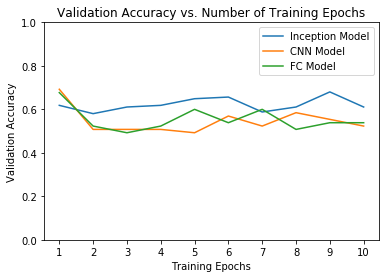

In [4]:
num_epochs = 10
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ihist,label="Inception Model")
plt.plot(range(1,num_epochs+1),cnn_hist,label="CNN Model")
plt.plot(range(1,num_epochs+1),nn_hist,label="FC Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [16]:
test_ihist = [0.5644983257229832, 0.5494172454946728, 0.5920852834808524, 0.5384915159817352, 0.5981735159817352, 0.5722983257229832, 0.5494672754946728, 0.5920852359208524, 0.5981735159817352, 0.5981735159817352,0.5920852359208524, 0.5996955859969558, 0.5844748858447488, 0.5875190258751902, 0.5905631659056316, 0.5890410958904109, 0.5920852359208524, 0.5890410958904109, 0.5875190258751902, 0.5951293759512937, 0.5966514459665144, 0.5799086757990868, 0.593607305936073, 0.5859969558599696, 0.6675190258751902, 0.6475190258751902, 0.6344748858447488, 0.6890410958904109, 0.6012176560121765, 0.5890410958904109]
test_chist =[0.4642313546423135, 0.4611872146118721, 0.4627092846270928, 0.4657534246575342, 0.4611872146118721,0.4924092846270928, 0.4733637747336377, 0.4733637747336377,  0.449292846270928,0.4581430745814307, 0.4627092846270928, 0.4627092846270928, 0.4550989345509893,0.473289345509893, 0.4611872146118721, 0.4642313546423135, 0.489313546423135,0.4657534246575342, 0.4687975646879756, 0.4748858447488584, 0.4642313546421425,0.4611872146118721, 0.4657534246575342, 0.4703196347031963, 0.4779299847792998, 0.471841704718417, 0.4840182648401826, 0.4809741248097412, 0.4916286149162861, 0.4627092846270928]
test_nnhist = [0.5525114155251141, 0.5555555555555556, 0.5312024353120244,0.5342465753424657, 0.5449010654490106, 0.5357686453576864, 0.5555555555555556,0.5402936424033485, 0.543756323433792, 0.5410294354490106,0.5327245294237245, 0.5464231354642313, 0.5127430654490106,0.5388127853881278, 0.5342465753424657, 0.5403348554033485, 0.5312024353120244, 0.5509893455098934, 0.5312024353120244, 0.5342465753424657, 0.5357686453576864, 0.5449010654490106, 0.5388127853881278, 0.5403348554033485, 0.54337899543379, 0.5372907153729072, 0.5403348554033485, 0.5357686453576864, 0.5418569254185692, 0.5312024353120244]
print(len(test_nnhist))


30


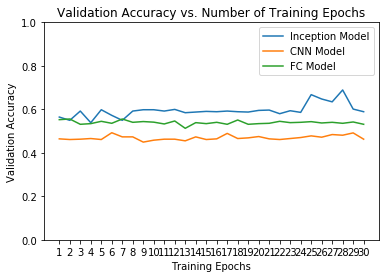

In [17]:
num_epochs = 30
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),test_ihist,label="Inception Model")
plt.plot(range(1,num_epochs+1),test_chist,label="CNN Model")
plt.plot(range(1,num_epochs+1),test_nnhist,label="FC Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Loss for 10

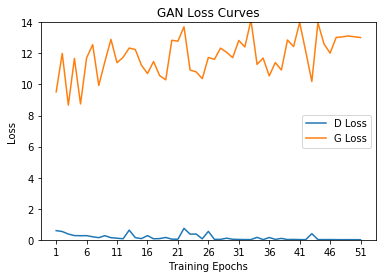

In [20]:
D_loss= [0.5907033681869507, 0.5320413112640381, 0.36996063590049744, 0.27134764194488525, 0.2621535658836365, 0.26768720149993896, 0.19483724236488342, 0.1375020444393158, 0.2651076018810272, 0.13590270280838013, 0.10150536894798279, 0.06736539304256439, 0.623406708240509, 0.13868525624275208, 0.07630904018878937, 0.2687493562698364, 0.06527867913246155, 0.07743427902460098, 0.1496904343366623, 0.041171032935380936, 0.03821645677089691, 0.736685037612915, 0.3638862371444702, 0.370208203792572, 0.06317629665136337, 0.5417271256446838, 0.027757981792092323, 0.027667488902807236, 0.10407461225986481, 0.034396905452013016, 0.02343783527612686, 0.01611160673201084, 0.014477244578301907, 0.15675088763237, 0.011742151342332363, 0.14624923467636108, 0.028198424726724625, 0.09019169211387634, 0.016427189111709595, 0.024320309981703758, 0.013768225908279419, 0.011236869730055332, 0.3941841125488281, 0.015556390397250652, 0.014835339039564133, 0.01565626822412014, 0.01101985014975071, 0.008350909687578678, 0.009265301749110222, 0.007569441106170416, 0.007463125977665186]
G_loss= [9.527863502502441, 11.999757766723633, 8.670832633972168, 11.681851387023926, 8.746126174926758, 11.715104103088379, 12.565521240234375, 9.935540199279785, 11.469871520996094, 12.90235710144043, 11.40008544921875, 11.754728317260742, 12.346830368041992, 12.248456001281738, 11.250673294067383, 10.705101013183594, 11.477694511413574, 10.571353912353516, 10.298636436462402, 12.846480369567871, 12.786836624145508, 13.714568138122559, 10.932103157043457, 10.809779167175293, 10.377647399902344, 11.738322257995605, 11.61750602722168, 12.339625358581543, 12.073246955871582, 11.728734970092773, 12.833951950073242, 12.41654109954834, 14.144179344177246, 11.296018600463867, 11.701415061950684, 10.551422119140625, 11.411806106567383, 10.933377265930176, 12.86369514465332, 12.439414024353027, 13.992422103881836, 12.124792098999023, 10.193833351135254, 13.975654602050781, 12.614204406738281, 12.020782470703125, 13.030166625976562, 13.065587997436523, 13.125768661499023, 13.070571899414062, 13.023078918457031]    
max_g = int(max(G_loss))
num_epochs = len(D_loss)
plt.title("GAN Loss Curves")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),D_loss,label="D Loss")
plt.plot(range(1,num_epochs+1),G_loss,label="G Loss")
plt.ylim((0,max_g))
plt.xticks(np.arange(1, num_epochs+1, 5.0))
plt.legend()
plt.show()

    

Loss for 100

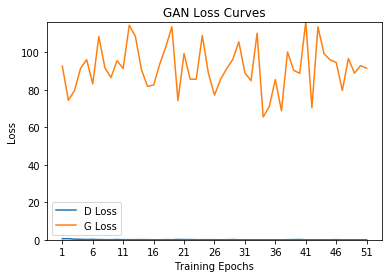

In [21]:
D_loss= [0.5914533138275146, 0.5956950187683105, 0.33521032333374023, 0.279453307390213, 0.1771048754453659, 0.2593061625957489, 0.13186877965927124, 0.08144992589950562, 0.048180997371673584, 0.17744463682174683, 0.06724779307842255, 0.06458230316638947, 0.04098543897271156, 0.1046043410897255, 0.050840698182582855, 0.03125806897878647, 0.023820597678422928, 0.08230775594711304, 0.041831742972135544, 0.19558507204055786, 0.0892801359295845, 0.10978676378726959, 0.04424875229597092, 0.0358121357858181, 0.05783423036336899, 0.03210895135998726, 0.030816582962870598, 0.04547571390867233, 0.13300855457782745, 0.021042337641119957, 0.01887723058462143, 0.011800135485827923, 0.010315838269889355, 0.010015862993896008, 0.009133584797382355, 0.008219710551202297, 0.007244099862873554, 0.054125286638736725, 0.10554993897676468, 0.13782164454460144, 0.01659865863621235, 0.024991178885102272, 0.01261492632329464, 0.02693554386496544, 0.011221266351640224, 0.07322760671377182, 0.008206344209611416, 0.00615682452917099, 0.005244274623692036, 0.005545581690967083, 0.04547100514173508]
G_loss= [92.65522766113281, 74.41395568847656, 79.57435607910156, 91.45104217529297, 96.11258697509766, 83.2088623046875, 108.42253112792969, 91.77137756347656, 86.58650970458984, 95.5986557006836, 91.32508850097656, 114.48690795898438, 108.63800048828125, 90.76960754394531, 81.86253356933594, 82.55499267578125, 93.64107513427734, 102.86568450927734, 113.643798828125, 74.23660278320312, 99.3310317993164, 85.69046020507812, 85.6612777709961, 109.01103210449219, 88.83876037597656, 77.15574645996094, 85.6298599243164, 91.27367401123047, 96.16985321044922, 105.6211929321289, 89.02374267578125, 84.86283111572266, 110.2109603881836, 65.5329360961914, 71.04034423828125, 85.4937744140625, 68.89266967773438, 100.16346740722656, 90.45121765136719, 88.76994323730469, 116.27799987792969, 70.50401306152344, 113.59263610839844, 99.28397369384766, 95.90267181396484, 94.63805389404297, 79.6659164428711, 96.72262573242188, 88.88056945800781, 92.91313934326172, 91.51045227050781]
max_g = int(max(G_loss))
num_epochs = len(D_loss)
plt.title("GAN Loss Curves")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),D_loss,label="D Loss")
plt.plot(range(1,num_epochs+1),G_loss,label="G Loss")
plt.ylim((0,max_g))
plt.xticks(np.arange(1, num_epochs+1, 5.0))
plt.legend()
plt.show()